# Classification. Linear models and KNN

In [112]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from collections import Counter

In [113]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(1.75 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [114]:
from sklearn.exceptions import NotFittedError

In [115]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=10000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        sigmoid = []
        x_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        for i in range(len(X)):
            sig = 1/(1+np.exp(-np.sum(X[i]*weights)))
            sigmoid.append(sig)
        return sigmoid
        pass
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        X_ext = np.hstack([np.ones((x.shape[0], 1)), x])
        #L = math.log(1 + math.exp(-y*np.dot(X_ext,weights)))
        #L = math.log(1+np.exp(-np.matmul(np.dot(X_ext,weights),y)))
        L = math.log(1+np.exp(-np.matmul(np.dot(X_ext, weights),y))) + (1/(2*self.C))*(np.linalg.norm(weights))**2
        return L
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        for i in range(self.max_iter):
            delta = ((np.matmul(y,X_ext)*(1-(1/(1+np.exp(-np.matmul(np.dot(X_ext,self.weights_),y)))))/y.size)-self.weights_/self.C)*-1
            self.weights_ -= self.eta * delta
            if (i > self.max_iter) or np.linalg.norm(delta) < self.tol:
                break
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        a = self.predict_proba(X)
        b = []
        for i in range(len(a)):
            if a[i] > 0.5:
                b.append(1)
            else:
                b.append(-1)
        #b = [np.where(a[i]>0.5,1,-1) for i in range(len(a))]
        return b

In [116]:
from sklearn import datasets
from sklearn import metrics

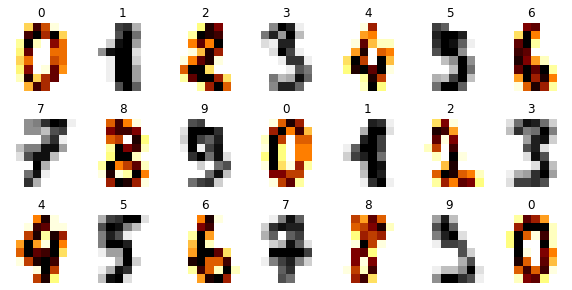

In [117]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [118]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [119]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [120]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [121]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [122]:
lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1]))

[0.5866175789173301, 0.401312339887548]

In [123]:
lr_clf.fit(X_train, y_train)

In [124]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [125]:
model = CustomLogisticRegression()

In [126]:
lr_clf.weights_

array([ 3.13152401e-06,  0.00000000e+00,  4.17536534e-05,  5.47668754e-04,
        2.21294363e-04,  4.87473904e-04,  1.35768963e-03,  5.97773138e-04,
        5.63674322e-05, -6.95894224e-07,  1.69102296e-04,  2.51913709e-04,
       -4.37021573e-04,  3.61864997e-04,  1.00487126e-03,  4.22755741e-04,
        2.57480863e-05,  3.47947112e-07, -1.14822547e-05, -7.24425887e-04,
       -2.62004175e-04,  8.75434934e-04,  4.15448852e-04, -8.42032011e-05,
       -5.21920668e-06,  0.00000000e+00, -2.21642310e-04, -5.71329158e-04,
        9.85734168e-04,  1.35073069e-03,  5.02087683e-04, -1.70494085e-04,
       -1.04384134e-06,  0.00000000e+00, -6.78148921e-04, -1.05149617e-03,
       -4.45372303e-05,  3.71607516e-04,  4.21016006e-04, -8.17675713e-05,
        0.00000000e+00, -5.21920668e-06, -5.34098817e-04, -2.03931802e-03,
       -8.43075852e-04,  1.04036186e-04, -1.23869172e-04, -1.78844816e-04,
       -1.32219903e-05, -4.52331246e-06, -9.42936674e-05, -1.11273486e-03,
       -5.09046625e-04, -

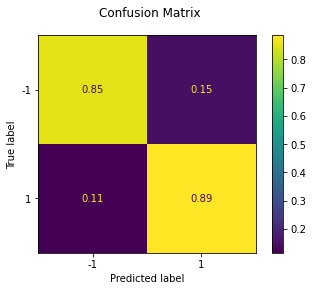

In [127]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [128]:
model

In [129]:
train_acc, test_acc

(0.8399443284620738, 0.8694444444444445)

In [130]:
assert min(train_acc, test_acc) > 0.83

**(0.5 points)** Visualize the loss history.

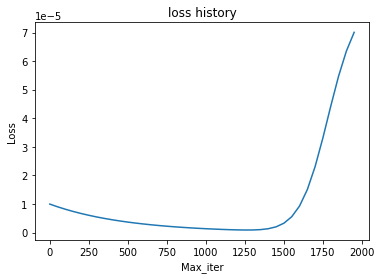

In [131]:
loss = []
it = []
for i in range(1, 2000, 50):
    lr_clf2 = CustomLogisticRegression(max_iter=i, zero_init=True)
    lr_clf2.fit(X_train, y_train)
    loss.append(lr_clf2.get_loss(X_train, lr_clf2.weights_, y_train))
    it.append(i)
plt.plot(it, loss)
plt.title('loss history')
plt.xlabel('Max_iter')
plt.ylabel('Loss')
plt.show()

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

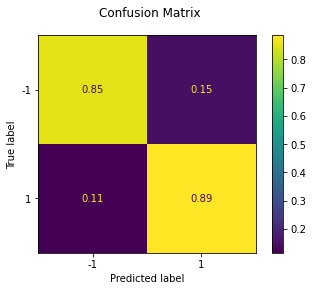

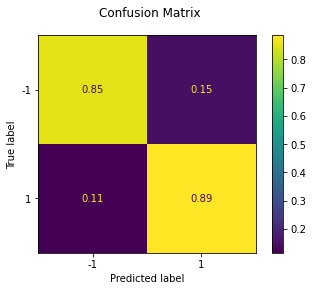

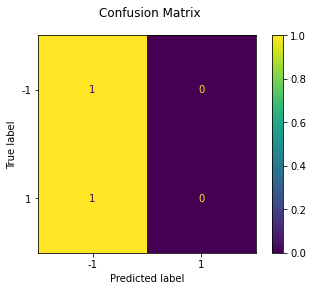

C:\Users\user\AppData\Local\Temp/ipykernel_13248/3365439797.py:64: RuntimeWarning: overflow encountered in exp
  delta = ((np.matmul(y,X_ext)*(1-(1/(1+np.exp(-np.matmul(np.dot(X_ext,self.weights_),y)))))/y.size)-self.weights_/self.C)*-1
C:\Users\user\AppData\Local\Temp/ipykernel_13248/3365439797.py:64: RuntimeWarning: overflow encountered in matmul
  delta = ((np.matmul(y,X_ext)*(1-(1/(1+np.exp(-np.matmul(np.dot(X_ext,self.weights_),y)))))/y.size)-self.weights_/self.C)*-1
C:\Users\user\AppData\Local\Temp/ipykernel_13248/3365439797.py:64: RuntimeWarning: invalid value encountered in matmul
  delta = ((np.matmul(y,X_ext)*(1-(1/(1+np.exp(-np.matmul(np.dot(X_ext,self.weights_),y)))))/y.size)-self.weights_/self.C)*-1


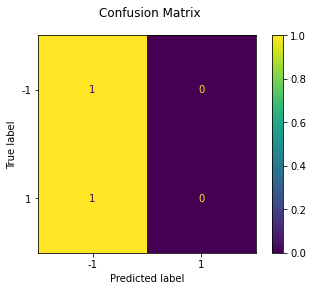

C:\Users\user\AppData\Local\Temp/ipykernel_13248/3365439797.py:64: RuntimeWarning: overflow encountered in exp
  delta = ((np.matmul(y,X_ext)*(1-(1/(1+np.exp(-np.matmul(np.dot(X_ext,self.weights_),y)))))/y.size)-self.weights_/self.C)*-1
C:\Users\user\AppData\Local\Temp/ipykernel_13248/3365439797.py:64: RuntimeWarning: overflow encountered in matmul
  delta = ((np.matmul(y,X_ext)*(1-(1/(1+np.exp(-np.matmul(np.dot(X_ext,self.weights_),y)))))/y.size)-self.weights_/self.C)*-1


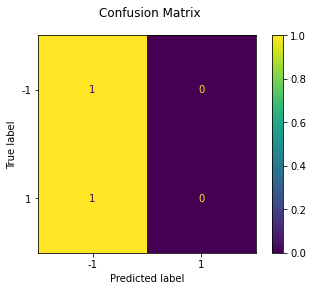

In [132]:
train_ac = []
test_ac = []
rates = [0.001,0.1,1, 10, 100]
for i in rates:
    lr_clf3 = CustomLogisticRegression(eta = i, max_iter=10000, zero_init=True)
    lr_clf3.fit(X_train, y_train)
    train_acc, test_acc = fit_evaluate(lr_clf3, X_train, y_train, X_test, y_test)
    train_ac.append(test_acc)
    test_ac.append(train_acc)
#plt.plot(it, loss)
#plt.title('loss history')
#plt.xlabel('Max_iter')
#plt.ylabel('Loss')
#plt.show()

In [133]:
print("Тренировочная точность -",train_ac,"\n", "При следующих learning rates", rates)

Тренировочная точность - [0.8694444444444445, 0.8694444444444445, 0.49166666666666664, 0.49166666666666664, 0.49166666666666664] 
 При следующих learning rates [0.001, 0.1, 1, 10, 100]


In [134]:
print("Тестовая точность -",test_ac,"\n", "При следующих learning rates", rates)

Тестовая точность - [0.8406402226861517, 0.8406402226861517, 0.4968684759916493, 0.4968684759916493, 0.4968684759916493] 
 При следующих learning rates [0.001, 0.1, 1, 10, 100]


Мы видим, что точность данного датасета при lr 0.001, 0.1 - одинакова, при lr 1+ модель перестает показывать адекватный результат

**(0.5 points)** Try different regularization parameter values and compare the model quality.

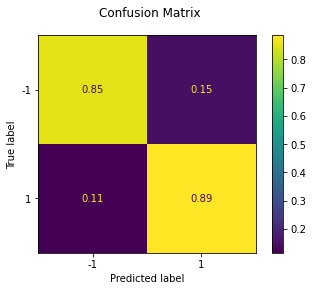

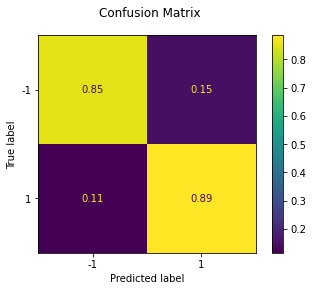

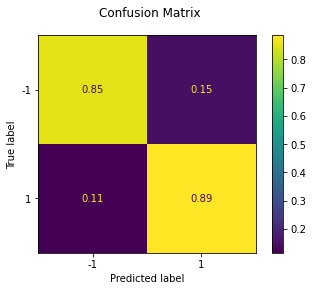

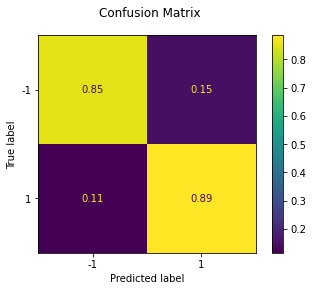

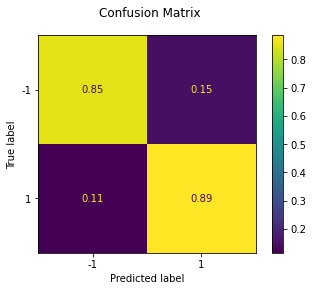

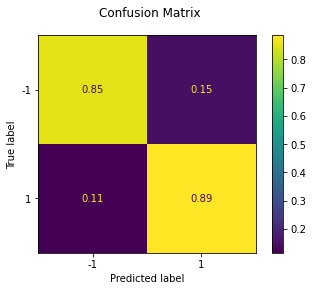

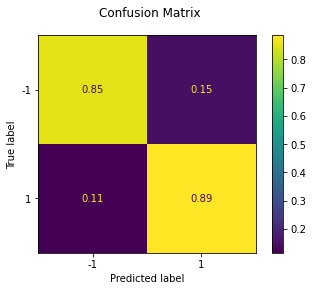

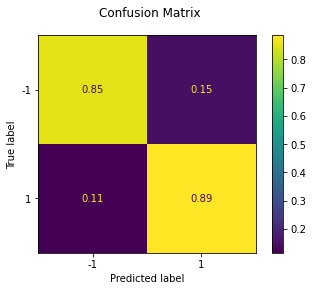

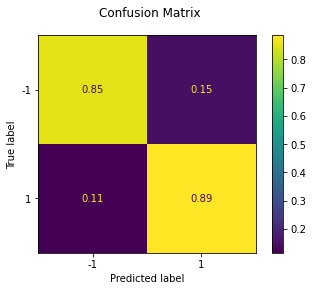

In [135]:
train_ac = []
test_ac = []
loss = []
C = [i/10 for i in range(1, 10, 1)]
for c in C:
    lr_clf4 = CustomLogisticRegression(max_iter=10000, C = c, zero_init=True)
    lr_clf4.fit(X_train, y_train)
    train_acc, test_acc = fit_evaluate(lr_clf4, X_train, y_train, X_test, y_test)
    loss.append(lr_clf4.get_loss(X_train, lr_clf4.weights_, y_train))
    train_ac.append(test_acc)
    test_ac.append(train_acc)

In [136]:
print("Тестовая точность -",test_ac,"\n", "При следующих C", C)

Тестовая точность - [0.8406402226861517, 0.8406402226861517, 0.8406402226861517, 0.8406402226861517, 0.8406402226861517, 0.8406402226861517, 0.8406402226861517, 0.8406402226861517, 0.8406402226861517] 
 При следующих C [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


In [137]:
print("loss -",loss,"\n", "При следующих C", C)

loss - [0.0006426898452652996, 0.00034771228919329384, 0.00024203957956825284, 0.00018691598752174781, 0.000152846217343722, 0.0001296055984614399, 0.00011268220765036847, 9.978580706966791e-05, 8.962302591243683e-05] 
 При следующих C [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


Мы видим, что точность модели не изменилась, однако значение loss меньше при большем значении C

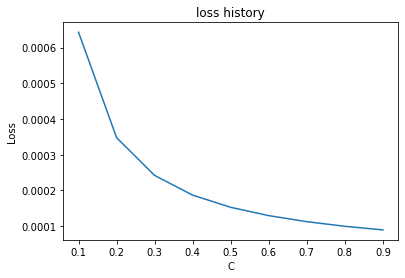

In [138]:
plt.plot(C, loss)
plt.title('loss history')
plt.xlabel('C')
plt.ylabel('Loss')
plt.show()

**(0.25 points)** Compare zero initialization and random initialization. 

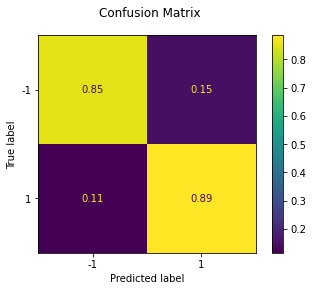

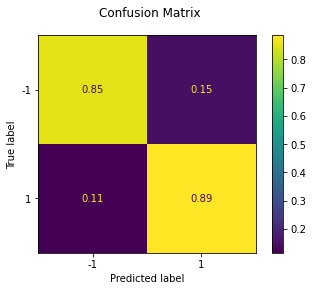

In [139]:
train_ac = []
test_ac = []
loss = []
zero_init = [True, False]
rand_st = [0, 42]
for i in range(len(rand_st)):
    lr_clf5 = CustomLogisticRegression(random_state=rand_st[i], zero_init=zero_init[i])
    lr_clf5.fit(X_train, y_train)
    train_acc, test_acc = fit_evaluate(lr_clf5, X_train, y_train, X_test, y_test)
    loss.append(lr_clf5.get_loss(X_train, lr_clf5.weights_, y_train))
    train_ac.append(test_acc)
    test_ac.append(train_acc)

In [140]:
loss[1]-loss[0]

9.96972350635815e-07

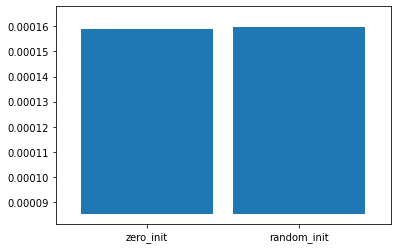

In [141]:
x_axis = ['zero_init', 'random_init']
fig, ax = plt.subplots()
ax.bar(x_axis, loss, width=1, edgecolor="white", linewidth=20, bottom = min(loss))
plt.show()

Loss практически идентичны, но при zero init он меньше на 9.96e-07

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(X points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [142]:
from scipy.spatial import distance_matrix

In [152]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        #distance = 0.0
        #for i in range(len(X)-1):
        #    distance += (X[i]-Y[i])**2
        return distance_matrix(X, Y)
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        frame_w = pd.DataFrame(data = [list(y), list(weights)], index = ['class','weights']).T
        frame_w = frame_w.groupby(by = ['class']).sum().reset_index()
        order = [i for i in range(len(self.classes_))]
        frame_ord = pd.DataFrame(data = [self.classes_, order], index = ['class', 'ord']).T
        full = pd.merge(frame_ord, frame_w, how = 'left', on = 'class')
        return full.sort_values(by = 'ord', ascending = True)['weights'].values.tolist()
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            p = []
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                order = [i for i in range(len(self.classes_))]
                frame_ord = pd.DataFrame(data = [order, self.classes_], index = ['ord','class']).T
                weights_of_points = [1/(P[i] + self.eps) for i in range(len(P))]
                for i in range(len(weights_of_points)):
                    frame = pd.DataFrame(data = [self.y, weights_of_points[i]], index = ['class', 'weight']).T
                    frame = frame.groupby(by = 'class').sum().reset_index()
                    frame_f = pd.merge(frame_ord, frame, how = 'left', on = 'class')
                    weight_class = frame_f.sort_values(by = 'ord', ascending = True)['weight'].values.tolist()
                    sum_class = model.get_class_weights(self.y, weights_of_points[i])
                    p_prob = [weight_class[i]/sum(sum_class) for i in range(len(weight_class))]
                    p.append(p_prob)
                return p
                #p = []
                #weights_of_points = [1/(P[i]+self.eps) for i in range(len(P))]
                #for i in range(len(weights_of_points)):
                #    sum_class = self.get_class_weights(self.y, weights_of_points[i])
                #    p_prob = [weights_of_points[x]/sum_class[x] for i in range(len(sum_class))]
                #    p.append(p_prob)
                #return p_prob
                
##############РЕАЛИЗОВАТЬ предикт не хватило сил и времени    
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        pass

In [144]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [145]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [146]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

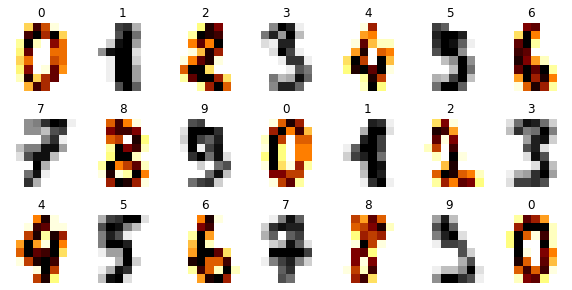

In [147]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [151]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

NotFittedError: CustomKNeighborsClassifier instance is not fitted yet

In [ ]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [ ]:
assert train_acc == 1
assert test_acc > 0.98

**(X points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

< your thoughts >

**(X points)** Try different n_neighbors parameters and compare the output probabilities of the model.

In [ ]:
## your code

< your thoughts >

**(X points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

In [ ]:
## your code

< your thoughts >

**(X points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

< your thoughts >

**(X points)** Suggest different task and distance function that you think would be suitable for it.

< your thoughts >

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [3]:
PATH = "./data/"

In [4]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [5]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Survived  100000 non-null  int64  
 1   Pclass    100000 non-null  int64  
 2   Name      100000 non-null  object 
 3   Sex       100000 non-null  object 
 4   Age       96708 non-null   float64
 5   SibSp     100000 non-null  int64  
 6   Parch     100000 non-null  int64  
 7   Ticket    95377 non-null   object 
 8   Fare      99866 non-null   float64
 9   Cabin     32134 non-null   object 
 10  Embarked  99750 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 9.2+ MB


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [7]:
data = data.reset_index()

In [8]:
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,1,2,"Bell, Adele",female,62.00,0,0,PC 15008,14.86,D17243,C
99996,99996,0,2,"Brown, Herman",male,66.00,0,0,13273,11.15,NaN,S
99997,99997,0,3,"Childress, Charles",male,37.00,0,0,NaN,9.95,NaN,S
99998,99998,0,3,"Caughlin, Thomas",male,51.00,0,1,458654,30.92,NaN,S


In [9]:
sex_surv = pd.pivot_table(data, values = 'PassengerId' ,index=['Sex', 'Survived'] , aggfunc='count').reset_index()

In [10]:
sex = pd.pivot_table(data, values = 'PassengerId' ,index=['Sex'] , aggfunc='count').reset_index()

In [11]:
sex

,Sex,PassengerId
0,female,43886
1,male,56114


In [12]:
sex_surv

,Sex,Survived,PassengerId
0,female,0,12660
1,female,1,31226
2,male,0,44566
3,male,1,11548


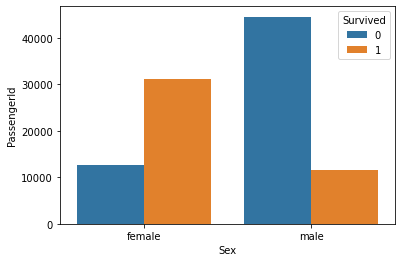

In [13]:
ax = sns.barplot(x="Sex", y="PassengerId", hue="Survived", data=sex_surv)

Доля выживших девушек 74%, мужчин 20%. Шанс выжить у девушки почти в 4 раза больше, чем у мужчины

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

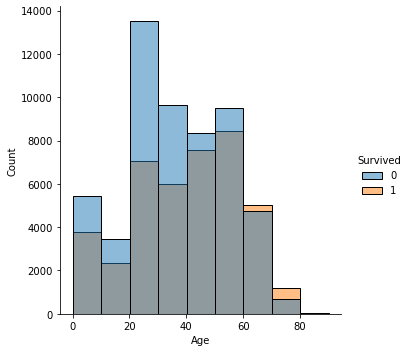

In [14]:
ax1 = sns.displot(data, x="Age", hue="Survived", binwidth = 10)


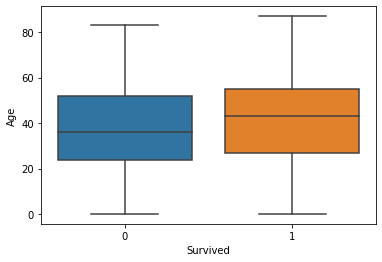

In [15]:
ax2 = sns.boxplot(x="Survived", y="Age", data=data)

In [16]:
surv = data[(data['Survived'] == 1)]
dec = data[(data['Survived'] == 0)]

In [17]:
surv['Age'].describe()

count    41418.000000
mean        40.553799
std         18.742172
min          0.080000
25%         27.000000
50%         43.000000
75%         55.000000
max         87.000000
Name: Age, dtype: float64

In [18]:
dec['Age'].describe()

count    55290.000000
mean        36.708695
std         17.809058
min          0.080000
25%         24.000000
50%         36.000000
75%         52.000000
max         83.000000
Name: Age, dtype: float64

Видно, что средний возраст выживших пассаиров больше в среднем на 4 года. на диаграмме распределения мы видим, что выживших пассажиров меньше, чем умерших распределении возраста до 60 лет, после 60 лет выживших пассажиров стало больше 

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

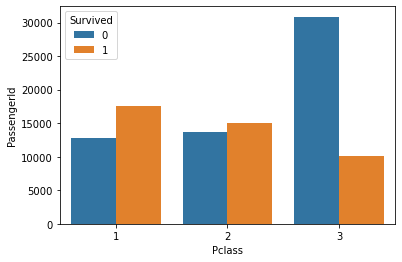

In [19]:
class_surv = pd.pivot_table(data, values = 'PassengerId' ,index=['Pclass', 'Survived'] , aggfunc='count').reset_index()
ax = sns.barplot(x="Pclass", y="PassengerId", hue="Survived", data=class_surv)

In [22]:

group_class = class_surv.groupby(by = 'Pclass').sum()['PassengerId'].reset_index()
class_surv_share = pd.merge(class_surv, group_class, how = 'left',on = 'Pclass')

In [23]:
class_surv_share['share'] = class_surv_share['PassengerId_x']/class_surv_share['PassengerId_y']

In [24]:
class_surv_share = class_surv_share[(class_surv_share['Survived'] == 1)]
class_surv_share.rename(columns = {'PassengerId_x':'QTY','PassengerId_y':'Total'}, inplace = True)

<AxesSubplot:xlabel='QTY', ylabel='share'>

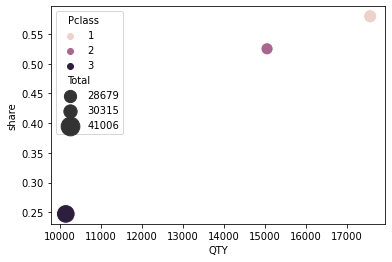

In [25]:
sns.scatterplot(data=class_surv_share, x="QTY", y="share", hue="Pclass", size = "Total", sizes=(150, 350))

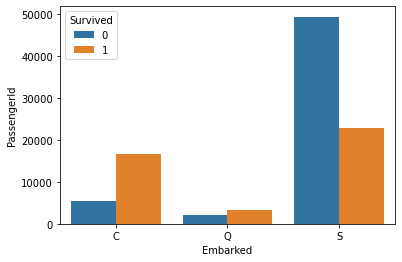

In [26]:
emb_surv = pd.pivot_table(data, values = 'PassengerId' ,index=['Embarked', 'Survived'] , aggfunc='count').reset_index()
ax = sns.barplot(x="Embarked", y="PassengerId", hue="Survived", data=emb_surv)

<AxesSubplot:xlabel='QTY', ylabel='share'>

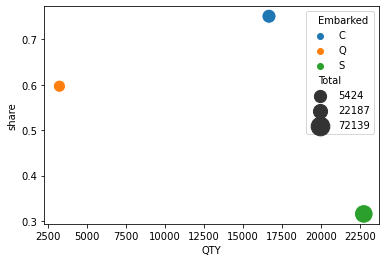

In [77]:
group_emb = emb_surv.groupby(by = 'Embarked').sum()['PassengerId'].reset_index()
class_emb_share = pd.merge(emb_surv, group_emb, how = 'left',on = 'Embarked')
class_emb_share['share'] = class_emb_share['PassengerId_x']/class_emb_share['PassengerId_y']
class_emb_share = class_emb_share[(class_emb_share['Survived'] == 1)]
class_emb_share.rename(columns = {'PassengerId_x':'QTY','PassengerId_y':'Total'}, inplace = True)
sns.scatterplot(data=class_emb_share, x="QTY", y="share", hue="Embarked", size = "Total", sizes=(150, 350))

Самый безопасный класс 1, доля выживших пассажиров более 55% 
по месту посадки больше всего пассажиров выжило в S, однако доля выживших составляет всего 30%, хоть и в C количество выживших меньше, но их доля около 80%. Поэтому порт C оказался самым счастливым

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [27]:
null_feat = data.isnull().sum().values.tolist()
null_feat_share = [(i/len(data))*100 for i in null_feat]
df_percentage = pd.DataFrame(data = [null_feat_share], columns = data.columns, index = ['share of missing values']).T

In [28]:
df_percentage.sort_values(by = 'share of missing values', ascending = False)

,share of missing values
Cabin,67.866
Ticket,4.623
Age,3.292
Embarked,0.250
Fare,0.134
PassengerId,0.000
Survived,0.000
Pclass,0.000
Name,0.000
Sex,0.000


In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   PassengerId  100000 non-null  int64  
 1   Survived     100000 non-null  int64  
 2   Pclass       100000 non-null  int64  
 3   Name         100000 non-null  object 
 4   Sex          100000 non-null  object 
 5   Age          96708 non-null   float64
 6   SibSp        100000 non-null  int64  
 7   Parch        100000 non-null  int64  
 8   Ticket       95377 non-null   object 
 9   Fare         99866 non-null   float64
 10  Cabin        32134 non-null   object 
 11  Embarked     99750 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 9.2+ MB


In [30]:
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,1,2,"Bell, Adele",female,62.00,0,0,PC 15008,14.86,D17243,C
99996,99996,0,2,"Brown, Herman",male,66.00,0,0,13273,11.15,NaN,S
99997,99997,0,3,"Childress, Charles",male,37.00,0,0,NaN,9.95,NaN,S
99998,99998,0,3,"Caughlin, Thomas",male,51.00,0,1,458654,30.92,NaN,S


Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

Cabin имеет 68% пустых данных, однако для построения модели данный признак нам не нужен, как и признак Ticket c 4.6% отсутсвующих данных. 
AGE и Fare мы можем заполнить средними значениями, 0.2% пустых embarked мы можем удалить

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [33]:
data['Age'].fillna(data['Age'].mean(),inplace = True)
data['Fare'].fillna(data['Fare'].mean(),inplace = True)

In [70]:
columns = ['Survived','Pclass','Sex','SibSp','Parch','Embarked','Age']
data_learn = data[columns]

In [71]:
data_learn.dropna(subset = ['Embarked'],inplace = True)

C:\Users\user\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [72]:
data_learn

,Survived,Pclass,Sex,SibSp,Parch,Embarked,Age
0,1,1,male,2,0,S,38.355472
1,0,3,male,0,0,S,38.355472
2,0,3,male,1,2,S,0.330000
3,0,3,male,0,0,S,19.000000
4,1,3,male,0,0,S,25.000000
...,...,...,...,...,...,...,...
99995,1,2,female,0,0,C,62.000000
99996,0,2,male,0,0,S,66.000000
99997,0,3,male,0,0,S,37.000000
99998,0,3,male,0,1,S,51.000000


In [73]:
data_dum = pd.get_dummies(data_learn, columns=['Pclass', 'Sex', 'Embarked'])

In [74]:
y = data_dum['Survived']
X = data_dum.drop(columns = ['Survived'])

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=22)

In [76]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

Y_pred = logreg.predict(X_test)

acc_log = round(logreg.score(X_train, y_train) * 100, 2)
acc_log

76.35

In [61]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, y_train) * 100, 2)

In [62]:
acc_knn

74.75

In [69]:
data_learn

,Survived,Pclass,Sex,SibSp,Parch,Embarked
0,1,1,male,2,0,S
1,0,3,male,0,0,S
2,0,3,male,1,2,S
3,0,3,male,0,0,S
4,1,3,male,0,0,S
...,...,...,...,...,...,...
99995,1,2,female,0,0,C
99996,0,2,male,0,0,S
99997,0,3,male,0,0,S
99998,0,3,male,0,1,S


In [77]:
data_learn['Age'] = data_learn['Age'].astype(int)
data_learn.loc[ data_learn['Age'] <= 11, 'Age'] = 0
data_learn.loc[(data_learn['Age'] > 11) & (data_learn['Age'] <= 18), 'Age'] = 1
data_learn.loc[(data_learn['Age'] > 18) & (data_learn['Age'] <= 22), 'Age'] = 2
data_learn.loc[(data_learn['Age'] > 22) & (data_learn['Age'] <= 27), 'Age'] = 3
data_learn.loc[(data_learn['Age'] > 27) & (data_learn['Age'] <= 33), 'Age'] = 4
data_learn.loc[(data_learn['Age'] > 33) & (data_learn['Age'] <= 40), 'Age'] = 5
data_learn.loc[(data_learn['Age'] > 40) & (data_learn['Age'] <= 66), 'Age'] = 6
data_learn.loc[ data_learn['Age'] > 66, 'Age'] = 6



C:\Users\user\AppData\Local\Temp/ipykernel_13248/1725725265.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_learn['Age'] = data_learn['Age'].astype(int)
C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [84]:
le = preprocessing.LabelEncoder()
le.fit(data_learn['Sex'])
labels = le.transform(data_learn['Sex'])

In [92]:
le = preprocessing.LabelEncoder()
le.fit(data_learn['Embarked'])
labelse = le.transform(data_learn['Embarked'])

In [93]:
data_learn['Sex_l'] = labels
data_learn['E_l'] = labelse

C:\Users\user\AppData\Local\Temp/ipykernel_13248/313224.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_learn['Sex_l'] = labels
C:\Users\user\AppData\Local\Temp/ipykernel_13248/313224.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_learn['E_l'] = labelse


In [89]:
data_learn.drop(columns = ['Sex'], inplace = True)

C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [94]:
data_learn.drop(columns = ['Embarked'], inplace = True)

C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [96]:
data_learn['Age_class'] = data_learn['Pclass']*data_learn['Age']

C:\Users\user\AppData\Local\Temp/ipykernel_13248/1130360354.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_learn['Age_class'] = data_learn['Pclass']*data_learn['Age']


In [98]:
y = data_learn['Survived']
X = data_learn.drop(columns = ['Survived'])

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=22)

In [100]:
logreg.fit(X_train, y_train)

Y_pred = logreg.predict(X_test)

acc_log = round(logreg.score(X_train, y_train) * 100, 2)
acc_log

69.53

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 4)
knn.fit(X_train, y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, y_train) * 100, 2)

In [102]:
acc_knn

67.28

1 вариант в котором мы используем get_dummies для обработки результата дает наиболее адекватный результат при использовани LogisticRegression = 76%

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [ ]:
## your code

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.0, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 3.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.